# Power analysis by bootstrap and inflation factors

This notebook will demonstrate how to conduct a power analysis for a one-sample design by using the `bootstrap_predictive_power_1samp` function from the `niseq.power.bootstrap` module. Then, it will show how inflation factors can be used to design a sequential test with the same power as a given fixed-sample test.

In this example, we'll just work with univariate data (so the notebook runs quickly), but usage should be similar for multivariate data. See [the API documentation](https://niseq.readthedocs.io/en/latest/index.html#module-niseq.power.bootstrap) for usage details, as well as details on the Bayesian bootstrap procedure and relevant citations.

## Power analysis for a fixed sample design


In [1]:
from niseq.spending_functions import PocockSpendingFunction
from niseq.max_test import sequential_permutation_t_test_1samp
from niseq.power.bootstrap import bootstrap_predictive_power_1samp
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy as np

To run a power analysis by bootstrap, you'll need some existing data (e.g. from an internal pilot study) from which to draw bootstrap resamples. We'll simulate 50 observations for this purpose.

In [2]:
np.random.seed(0)
x = norm.rvs(loc = .7, size = 50) # data to resample from

Now, if we want to estimate the statistical power of a specific (sequential or fixed sample) design, we can use `bootstrap_predictive_power_1samp`. To specify a fixed-sample design, just set `look_times = [n_max]`.

In [3]:
n_fixed = 30
alpha = .05

res = bootstrap_predictive_power_1samp(
    x, 
    test_func = sequential_permutation_t_test_1samp, # or any 1samp test in niseq!
    look_times = [n_fixed], n_max = n_fixed, 
    alpha = alpha,
    seed = 1, n_jobs = -1
)
power_fixed = res['cumulative_power'][0]
print('Fixed sample power is ' + str(power_fixed))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.3min


Fixed sample power is 0.962890625


[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  1.5min finished


## Inflation Factors

In general, for a sequential design to acheive the same statistical power as a fixed sample design, the sequential design's maximum sample size needs to be larger. How much larger? That can be predicted with an _inflation factor_, which depends only on the sequential design's characteristics (i.e. number/timing of looks, alpha spending function used) and the desired Type II error. Technically, inflation factors are only guaranteed to be valid for parametric approaches to alpha spending (which depend on some normality assumptions that our permutation-based approach doesn't require). But empirically, it seems that inflation factors for parametric alpha spending translate well to permutation alpha spending, despite the lack of associated theoretical guarantees.

`niseq` doesn't have any built-in functionality to compute inflation factors, but you can use another package to get them. The R packages `rpact` and `gsDesign` are good options. 

In [4]:
def get_inflation_factor(beta, n_looks = 3, spending_type = 'asP'):
    '''
    Computes inflation factor for a sequential design with evenly spaced looks.
    
    Arguments
    ---------
    beta : float
        The Type II error of the fixed sample design 
        that's power you're trying to match.
    n_looks : int
        The number of (evenly spaced) looks at the data.
    spending_type : 'asP' | 'asOF', default: 'asP'
        'asP' uses a Pocock spending function (default)
        'asOF' uses an OBrien Fleming spending function
        
    Returns
    --------
    inflation : float
        The factor by which one must multiply the sample size of a fixed
        sample design with Type II error ``beta`` to yield the maximum sample
        size required for a sequential test of the specified design to 
        acheive the same Type II error. 
        
    Notes
    -------
    Requires R to be installed in your environment. 
    
    '''
    from rpy2 import robjects
    fv = robjects.r(
        '''
        if (!('rpact' %%in%% installed.packages())) {install.packages('rpact', type = 'source')}
        design <- rpact::getDesignGroupSequential(kMax = %d, beta = %f, typeOfDesign = '%s')
        chars <- rpact::getDesignCharacteristics(design)
        chars$inflationFactor
        '''%(n_looks, beta, spending_type)
    )
    return fv[0]

inflation = get_inflation_factor(1 - power_fixed)
print('inflation factor: %f'%inflation)

inflation factor: 1.138948


In [5]:
# use inflation factor to predict max n needed to match fixed n's power
n_max = int(np.floor(n_fixed * inflation) + 1) # round up
n_max

35

**Note:** Pocock spending functions usually entail higher inflation factors than many other spending functions; O'Brien Fleming, in contrast, tends to result in modest inflation factors. Moreover, the more interim looks you do, the higher the inflation factor. 

Now, let's run a power analysis for the specified sequential design to see if the power matches as expected. 

## Power analysis for a sequential design

In [6]:
look_times = [n_max//3, 2*n_max//3, n_max]

results = bootstrap_predictive_power_1samp(
    x, sequential_permutation_t_test_1samp, 
    look_times, n_max, 
    alpha = alpha,
    seed = 1, n_jobs = -1,
    spending_func = PocockSpendingFunction(alpha, n_max)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  2.2min finished


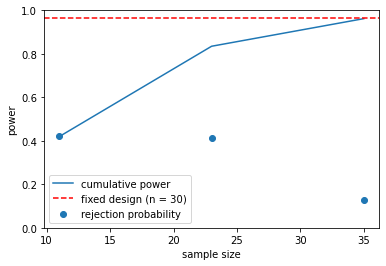

Expected sample size: 19.94
Sample size savings: 33.53 percent


In [7]:
plt.plot(look_times, results['cumulative_power'], label = 'cumulative power')
plt.axhline(power_fixed, color = 'red', label = 'fixed design (n = %d)'%n_fixed, linestyle = '--')
plt.scatter(look_times, results['rejection_probability'], label = 'rejection probability')
plt.ylabel('power')
plt.xlabel('sample size')
plt.ylim((0, 1))
plt.legend()
plt.show()

n_exp = results['n_expected']
print('Expected sample size: %.2f'%n_exp)
print('Sample size savings: %.2f percent'%(100*(n_fixed - n_exp)/n_fixed))

Note that, even though the _maximum_ sample size for the sequential design is larger than the fixed-sample design with the same power (i.e. inflation factor is greater than one), the _expected_ sample size is actually a good bit smaller. This is where the efficiency advantage of sequential designs shine; the probability of rejecting the null hypothesis at an interim analysis is substantial. (And this efficiency gain is usually larger for high-powered designs.)

In [8]:
results

{'uncorr_instantaneous_power': [0.58984375, 0.91015625, 0.9794921875],
 'rejection_probability': [0.419921875, 0.4150390625, 0.126953125],
 'cumulative_power': [0.419921875, 0.8349609375, 0.9619140625],
 'uncorr_cumulative_power': [0.58984375, 0.9140625, 0.982421875],
 'n_expected': 19.94140625,
 'n_simulations': 1024,
 'n_orig_data': 50,
 'conditional': False,
 'test_func': 'sequential_permutation_t_test_1samp',
 'test_func_kwargs': {'alpha': 0.05,
  'spending_func': 'PocockSpendingFunction',
  'look_times': [11, 23, 35],
  'n_max': 35}}